In [42]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 3.5 MB/s eta 0:00:00


In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [44]:
# Import all necessary packages

# https://towardsdatascience.com/nlp-preprocessing-with-nltk-3c04ee00edc0
# nltk.download('punkt')
# nltk.download('stopwords')
import nltk
import numpy as np
import string
import snscrape.modules.twitter as sntwitter
import pandas as pd
import wordcloud as wc
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import torch
import time
import datetime
import matplotlib.pyplot as plt
import yfinance as yf

In [4]:
# Data Scraping Code
def scrape_data(company, ipo_date):
    start = time.time()
    print("Starting at " + str(start))
    # generate date intervals
    end = datetime.datetime.strptime(ipo_date, "%Y-%m-%d")
    date_generated = [end - datetime.timedelta(days=x) for x in range(8)]
    date_generated = list(reversed(date_generated))
    
    print('Tweets for ' + company + ' will be scraped from ' + date_generated[0].strftime("%Y-%m-%d") + ' to ' + date_generated[-1].strftime("%Y-%m-%d"))
    print('Sleeping for 5 seconds')
    print()
    time.sleep(5)
    
    # store twitter query strings
    query_strings = []
    for i in range(len(date_generated) - 1):
        query_string = ""
        query_string += company
        query_string += " ipo "
        query_string += " since:"
        query_string += date_generated[i].strftime("%Y-%m-%d")
        query_string += " until:"
        query_string += date_generated[i + 1].strftime("%Y-%m-%d")
        query_strings.append(query_string)
    
    print('Query strings generated')
    print('Sleeping for 5 seconds')
    print()
    time.sleep(5)
    
    # generate data day by day
    data = []
    counter = 1
    for query_string in query_strings:
        notification_string = "Dataset " + str(counter) + " finished scraping"
        for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query_string).get_items()):
            data.append(tweet)
            if i > 10000:
                break
        %notify -m "Dataset finished scraping"
        print(notification_string)
        counter += 1
    final_raw = pd.DataFrame(data)
    company_string = company + '.csv'
    print('Generating file for ' + company_string)
    final_raw.to_csv(company_string)
    print('File generated')
    end = time.time()
    print("Ending at " + str(end))
    print("Operation took " + str(end - start) + " seconds")
    print('All done!')    

In [49]:
# YMD
# Alibaba: 2014-09-19
# Facebook: 2012-05-18
# Uber: 2019-05-09
# Rivian: 2021-11-09
# Didi: 2021-06-30
# Coupang: 2021-03-11
# Banco Santander: 2009-10-07
# GM: 2010-11-17
# Visa: 2008-03-19
# AirBNB: 2020-12-10

scrape_data('alibaba', '2014-09-19')
scrape_data('facebook', '2012-05-18')
scrape_data('uber', '2019-05-09')
scrape_data('rivian', '2021-11-09')
scrape_data('didi', '2021-06-30')
scrape_data('coupang', '2021-03-11')
scrape_data('banco santander', '2009-10-07')
scrape_data('general motors', '2010-11-17')
scrape_data('visa', '2008-03-19')
scrape_data('airbnb', '2020-12-10')

Starting at 1673469711.250818
Tweets for alibaba will be scraped from 2014-09-12 to 2014-09-19
Sleeping for 5 seconds



KeyboardInterrupt: 

In [150]:
# File Processing Code
def process(filename):
    # Load File as CSV, get text
    file_raw = pd.read_csv(filename, low_memory=False, lineterminator='\n')
    raw_text = file_raw[['content', 'date']].copy()

    # Remove Non-Alphanumeric Characters, make lowercase, tokenize
    raw_text = raw_text.replace('[^a-zA-Z0-9 ]', '', regex=True)
    raw_text['content'] = raw_text['content'].str.lower()
    raw_text['content'] = raw_text['content'].apply(nltk.word_tokenize)
    
    # post tokenization operations: remove URL string, remove non-English words, remove stopwords, stem
    words = set(nltk.corpus.words.words())
    stopwords = set(nltk.corpus.stopwords.words("english"))
#     porter = PorterStemmer()
    
    def check_word(word):
        if ('http' not in word) and (word in words) and (word not in stopwords):
            return True
        return False

#     raw_text['content'] = raw_text['content'].apply(lambda row : [porter.stem(word) for word in row if check_word(word)])    

    # Rejoin Words
    raw_text['text'] = raw_text['content'].apply(lambda row: ' '.join(row))
    
    # Add Length Column, remove empty tweets
    raw_text['Length'] = raw_text['content'].apply(len)
    raw_text = raw_text[raw_text['Length'] > 0].copy()
    return raw_text 

In [151]:
alibaba = process('alibaba.csv')  
facebook = process('facebook.csv')  
uber = process('uber.csv')  
rivian = process('rivian.csv')  
didi = process('didi.csv')  
coupang = process('coupang.csv')  
banco_santander = process('banco santander.csv')  
general_motors = process('general motors.csv')  
visa = process('visa.csv')  
airbnb = process('airbnb.csv')  

In [184]:
dataframes = {
    'alibaba' : alibaba,
    'facebook': facebook,
    'uber' : uber,
    'rivian' : rivian,
    'didi' : didi,
    'coupang' : coupang,
    'banco' : banco_santander,
    'gm' : general_motors,
    'visa' : visa,
    'airbnb' : airbnb
}

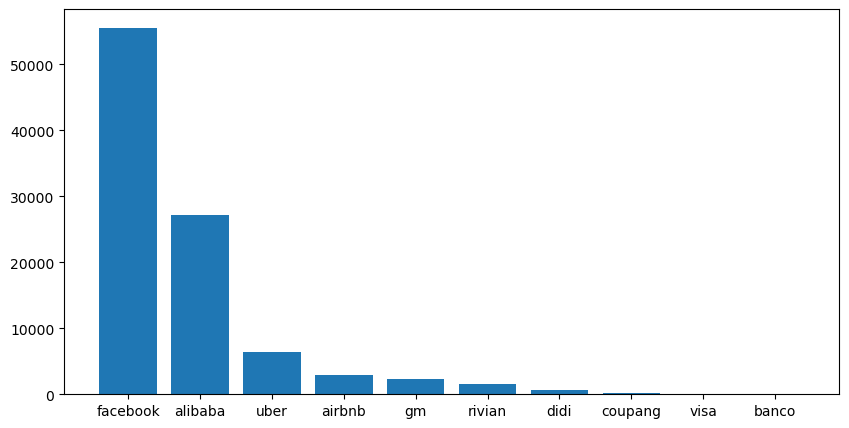

In [38]:
# Dataset Sizes
courses = list(dataframes.keys())
values = [len(x) for x in dataframes.values()]
zipped = list(zip(courses, values))
zipped.sort(key=lambda x:x[1])
zipped = reversed(zipped)
courses, values = zip(*zipped)
courses, values = list(courses), list(values)

f = plt.figure(figsize = (10, 5))
plt.bar(courses, values)
plt.show()

In [367]:
# Stock Visualizations
tickers = {'facebook':'META',
           'alibaba':'BABA',
           'uber':'UBER',
           'airbnb':'ABNB',
           'gm':'GM',
           'rivian':'RIVN',
           'didi':'DIDIY',
           'coupang':'CPNG',
           'visa':'V',
           'banco':'BSBR'}

ipo_starts = {'alibaba':'2014-09-18',
             'facebook':'2012-05-17',
             'uber':'2019-05-08',
             'rivian':'2021-11-09',
             'didi':'2021-06-29',
             'coupang':'2021-03-10',
             'banco':'2009-10-06',
             'gm':'2010-11-16',
             'visa':'2008-03-18',
             'airbnb':'2020-12-09'
            }

ipo_ends = {'alibaba':'2014-12-17',
             'facebook':'2012-08-16',
             'uber':'2019-08-08',
             'rivian':'2022-02-09',
             'didi':'2021-09-28',
             'coupang':'2021-06-09',
             'banco':'2010-01-06',
             'gm':'2011-02-17',
             'visa':'2008-06-17',
             'airbnb':'2021-03-12'
            }

keys = tickers.keys()
historicals = {
    key
    :
    yf.Ticker(tickers[key]).history(start=ipo_starts[key], end=ipo_ends[key], interval='1d')
    for key in keys
}
opens = {key : historicals[key]['Open'] for key in keys}
highs = {key : historicals[key]['High'] for key in keys}
lows = {key : historicals[key]['Low'] for key in keys}
closes = {key : historicals[key]['Close'] for key in keys}
initials = {key : opens[key][0] for key in keys}


def normalize(df, key):
    initial = initials[key]
    for i in range(len(df)):
        df[i] = df[i] / initial
    return df

for key in keys:
    print(key)
    opens[key] = normalize(opens[key], key)
    print('opens')
    print(opens[key].mean())
    highs[key] = normalize(highs[key], key)
    print('highs')
    print(highs[key].mean())
    lows[key] = normalize(lows[key], key)
    print('lows')
    print(lows[key].mean())
    closes[key] = normalize(closes[key], key)
    print('closes')
    print(closes[key].mean())
    print()

facebook
opens
0.6761229064432274
highs
0.6904376653712848
lows
0.6558398325191163
closes
0.6693375876331642

alibaba
opens
1.0827061266564912
highs
1.099967667529172
lows
1.0644413497066016
closes
1.0816108450918942

uber
opens
1.0195560616465391
highs
1.035394007892286
lows
0.998895163177162
closes
1.0163709696170553

airbnb
opens
1.2003366113815275
highs
1.2462324386037034
lows
1.1544028993101707
closes
1.1983418028490553

gm
opens
1.0269402555671314
highs
1.0372582326882107
lows
1.01388956040249
closes
1.026364223742826

rivian
opens
0.9179196191660774
highs
0.954575055277923
lows
0.8660962464379484
closes
0.911753419393534

didi
opens
0.5771723441315233
highs
0.5991552960964353
lows
0.5553095142073642
closes
0.5759759895602267

coupang
opens
0.6808890036771162
highs
0.6963853194140104
lows
0.6561061761268419
closes
0.6722453676688359

visa
opens
1.2662184493700352


/var/folders/_t/x60g41d57c71w5w09k_c4h180000gn/T/ipykernel_26110/1478140803.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df[i] / initial


highs
1.2938898883376027
lows
1.238330133734361
closes
1.2658416447412197

banco
opens
0.9974107651998475
highs
1.0125307076729504
lows
0.9785622257353551
closes
0.9956387839659682



In [359]:
for key in opens:
    print(key)

facebook
alibaba
uber
airbnb
gm
rivian
didi
coupang
visa
banco


In [360]:
opens

{'facebook': Date
 2012-05-18 00:00:00-04:00    1.000000
 2012-05-21 00:00:00-04:00    0.868728
 2012-05-22 00:00:00-04:00    0.775505
 2012-05-23 00:00:00-04:00    0.746017
 2012-05-24 00:00:00-04:00    0.783591
                                ...   
 2012-08-09 00:00:00-04:00    0.493460
 2012-08-10 00:00:00-04:00    0.509156
 2012-08-13 00:00:00-04:00    0.526754
 2012-08-14 00:00:00-04:00    0.509156
 2012-08-15 00:00:00-04:00    0.490844
 Name: Open, Length: 62, dtype: float64,
 'alibaba': Date
 2014-09-19 00:00:00-04:00    1.000000
 2014-09-22 00:00:00-04:00    1.000000
 2014-09-23 00:00:00-04:00    0.959439
 2014-09-24 00:00:00-04:00    0.954369
 2014-09-25 00:00:00-04:00    0.982632
                                ...   
 2014-12-10 00:00:00-05:00    1.155232
 2014-12-11 00:00:00-05:00    1.126645
 2014-12-12 00:00:00-05:00    1.129450
 2014-12-15 00:00:00-05:00    1.147681
 2014-12-16 00:00:00-05:00    1.119202
 Name: Open, Length: 62, dtype: float64,
 'uber': Date
 2019-05-10

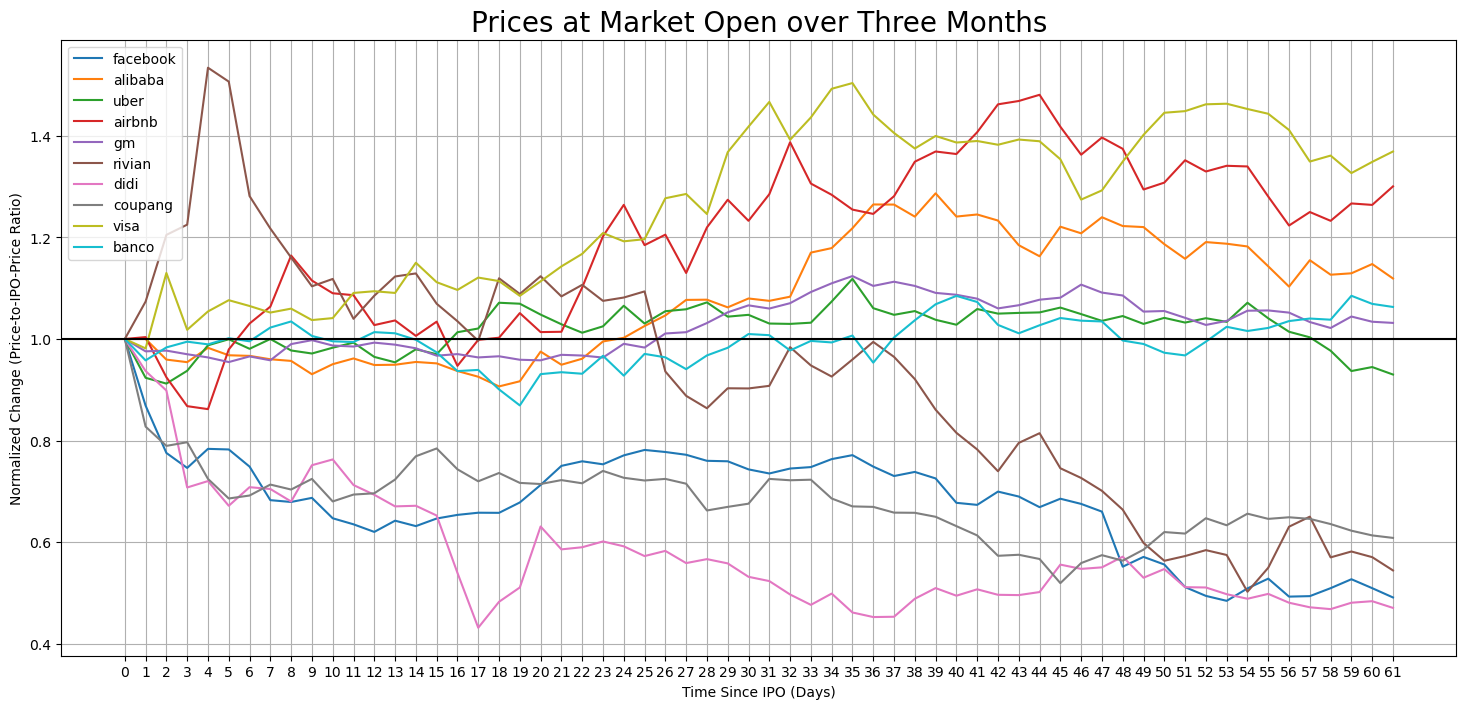

In [361]:
f = plt.figure(figsize = (18, 8))
x_axis = [i for i in range(len(opens['facebook']))]
for key in opens:
    plt.plot(x_axis, opens[key], label=key)

plt.title('Prices at Market Open over Three Months', fontsize='20')
plt.xlabel('Time Since IPO (Days)')
plt.ylabel('Normalized Change (Price-to-IPO-Price Ratio)')
plt.legend()

plt.grid()
plt.xticks(x_axis)
plt.axhline(y=1, color='k', linestyle='-')
plt.show()

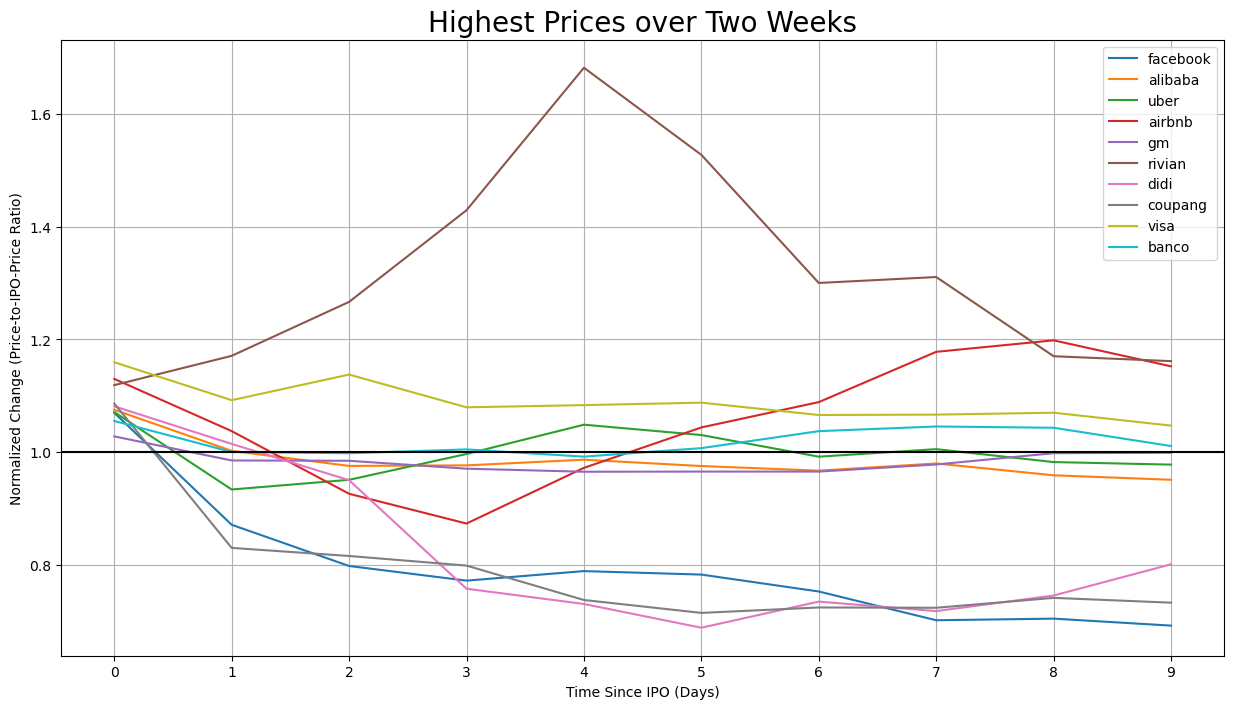

In [287]:
f = plt.figure(figsize = (15, 8))
x_axis = [i for i in range(10)]
for key in highs:
    plt.plot(x_axis, highs[key], label=key)

plt.title('Highest Prices over Two Weeks', fontsize='20')
plt.xlabel('Time Since IPO (Days)')
plt.ylabel('Normalized Change (Price-to-IPO-Price Ratio)')
plt.legend()

plt.grid()
plt.xticks(x_axis)
plt.axhline(y=1, color='k', linestyle='-')
plt.show()

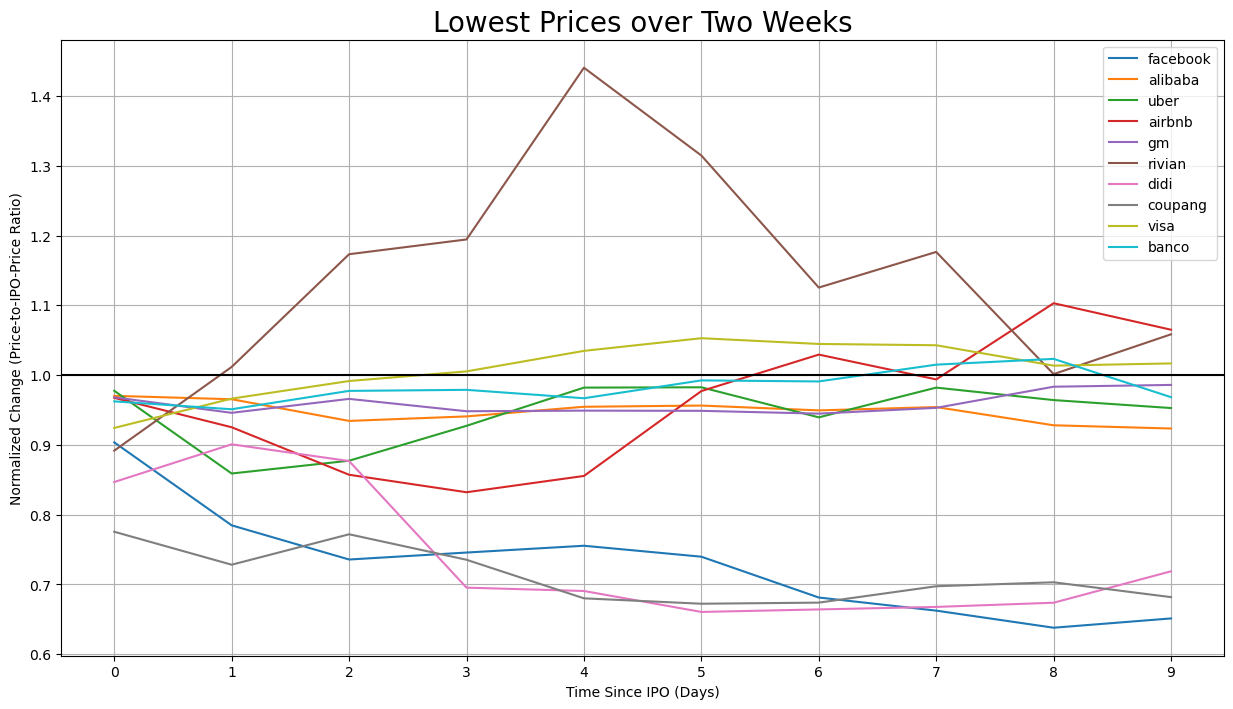

In [288]:
f = plt.figure(figsize = (15, 8))
x_axis = [i for i in range(10)]
for key in lows:
    plt.plot(x_axis, lows[key], label=key)

plt.title('Lowest Prices over Two Weeks', fontsize='20')
plt.xlabel('Time Since IPO (Days)')
plt.ylabel('Normalized Change (Price-to-IPO-Price Ratio)')
plt.legend()

plt.grid()
plt.xticks(x_axis)
plt.axhline(y=1, color='k', linestyle='-')
plt.show()

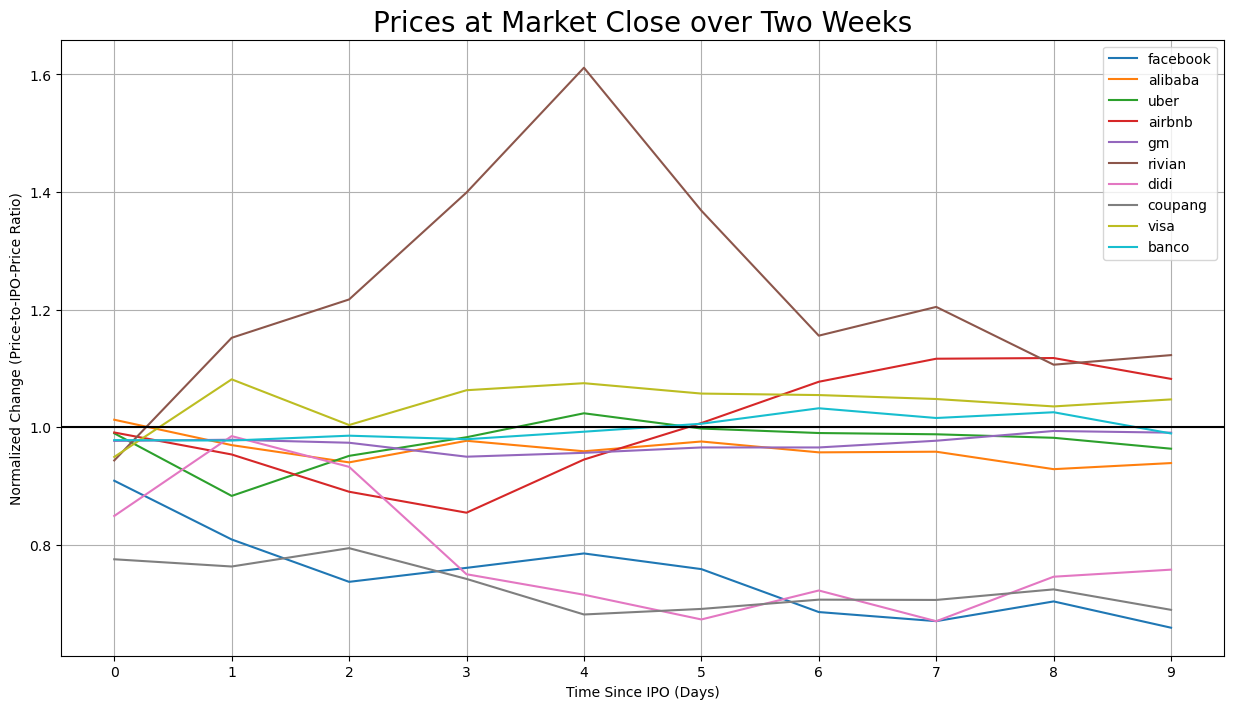

In [290]:
f = plt.figure(figsize = (15, 8))
x_axis = [i for i in range(10)]
for key in closes:
    plt.plot(x_axis, closes[key], label=key)

plt.title('Prices at Market Close over Two Weeks', fontsize='20')
plt.xlabel('Time Since IPO (Days)')
plt.ylabel('Normalized Change (Price-to-IPO-Price Ratio)')
plt.legend()

plt.grid()
plt.xticks(x_axis)
plt.axhline(y=1, color='k', linestyle='-')
plt.show()

In [152]:
def add_sentiment(dataframe):
    def get_row_sent(row):
        finbert_result = finbert_pipeline(row)[0]
        label = finbert_result['label']
        if label == 'positive':
            return 1
        elif label == 'neutral':
            return 0
        elif label=='negative':
            return -1
        
    dataframe['sid_sentiment'] = dataframe['text'].apply(lambda row: sid_obj.polarity_scores(row)['compound'])
    dataframe['finbert_label'] = dataframe['text'].apply(lambda row: get_row_sent(row))    

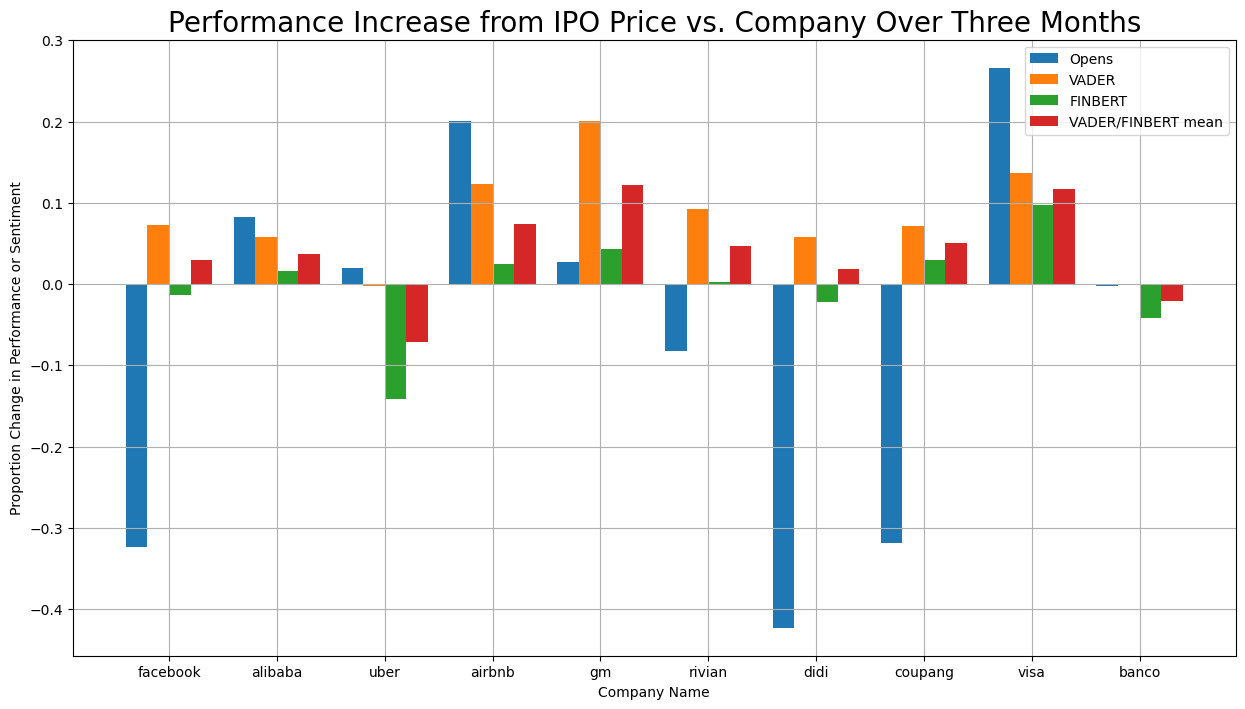

In [364]:
width = 0.2
x_axis = [i for i in range(10)]
f = plt.figure(figsize = (15, 8))
open_bar = plt.bar(np.array(x_axis)-0.3, [opens[key].mean() - 1 for key in keys], width, label='Opens')
vader_bar = plt.bar(np.array(x_axis) -0.1, [dataframes[key]['sid_sentiment'].mean() for key in keys], width, label='VADER')
finbert_bar = plt.bar(np.array(x_axis) + 0.1, [dataframes[key]['finbert_label'].mean() for key in keys], width, label='FINBERT')
mean_bar = plt.bar(np.array(x_axis) + 0.3, [(dataframes[key]['sid_sentiment'].mean() + dataframes[key]['finbert_label'].mean())/2 for key in keys], width, label='VADER/FINBERT mean')
# for key in closes:
#     vader = 
#     finbert = dataframes[dataframe]['finbert_label'].mean()
#     mean = (vader + finbert)/2
#     plt.bar(x_axis, opens[key].mean(), width)
#     plt.bar(x_axis + width, dataframes[key])

plt.title('Performance Increase from IPO Price vs. Company Over Three Months', fontsize='20')
plt.xlabel('Company Name')
plt.ylabel('Proportion Change in Performance or Sentiment')
plt.legend()

plt.grid()
plt.xticks(x_axis, [key for key in keys])
plt.show()

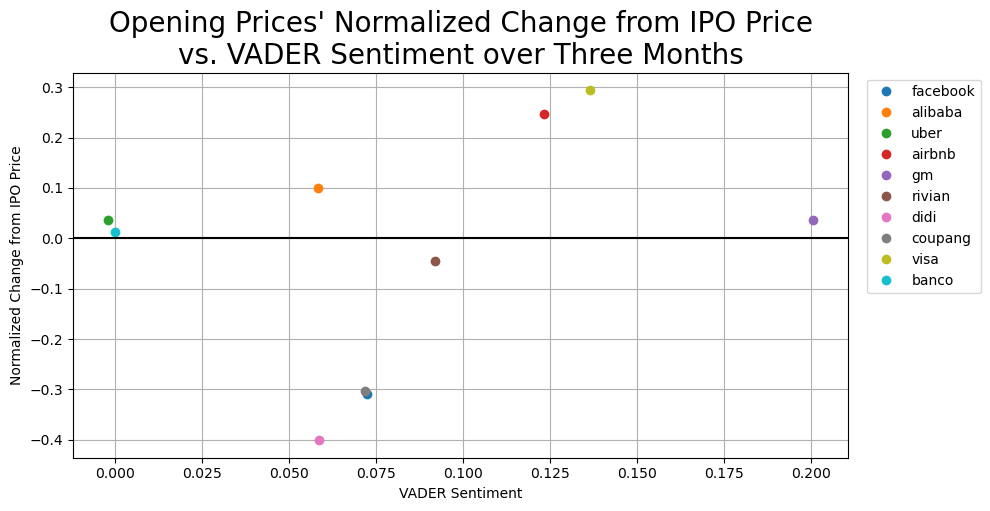

In [365]:
# relationship with sid sentiment on x axis and stock performance on y axis. Two plots.
f = plt.figure(figsize = (10, 5))
for key in keys:
    plt.plot(dataframes[key]['sid_sentiment'].mean(), highs[key].mean() - 1, 'o', label=key)

plt.title('Opening Prices\' Normalized Change from IPO Price\nvs. VADER Sentiment over Three Months', fontsize=20)
plt.xlabel('VADER Sentiment')
plt.ylabel('Normalized Change from IPO Price')
ax = plt.subplot(111)
ax.legend(loc='upper right', bbox_to_anchor=(1.18, 1))

plt.grid()
plt.axhline(y=0, color='k', linestyle='-')
plt.show()

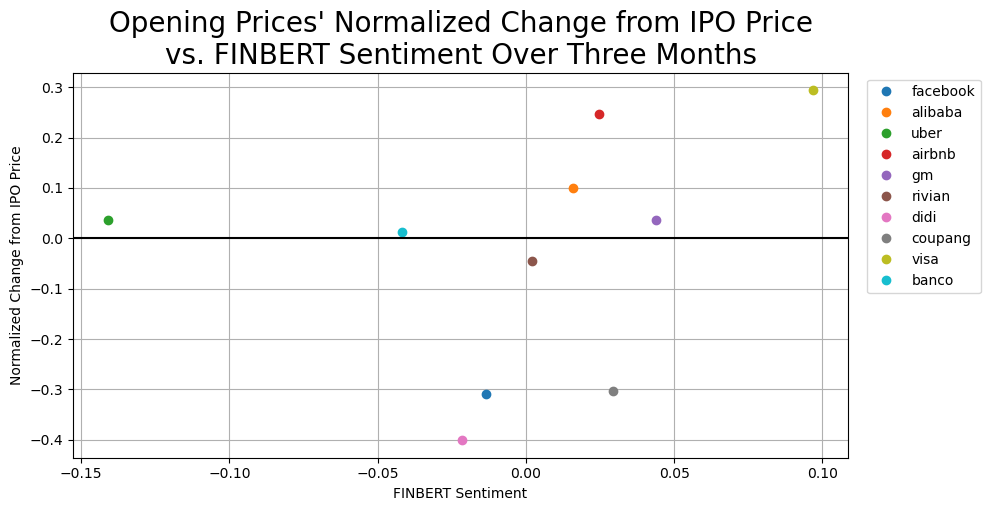

In [366]:
# relationship with sid sentiment on x axis and stock performance on y axis. Two plots.
f = plt.figure(figsize = (10, 5))
for key in keys:
    plt.plot(dataframes[key]['finbert_label'].mean(), highs[key].mean() - 1, 'o', label=key)

plt.title('Opening Prices\' Normalized Change from IPO Price\nvs. FINBERT Sentiment Over Three Months', fontsize=20)
plt.xlabel('FINBERT Sentiment')
plt.ylabel('Normalized Change from IPO Price')
ax = plt.subplot(111)
ax.legend(loc='upper right', bbox_to_anchor=(1.18, 1))

plt.grid()
plt.axhline(y=0, color='k', linestyle='-')
plt.show()

In [186]:
for key in dataframes:
    dataframes[key] = pd.read_csv(key + '_sentiment.csv', low_memory=False, lineterminator='\n')

In [187]:
dataframes

{'alibaba':        Unnamed: 0                                            content  \
 0               0                ['close', 'order', 'book', 'earli']   
 1               1       ['closer', 'look', 'loom', 'home', 'abroad']   
 2               2       ['closer', 'look', 'loom', 'home', 'abroad']   
 3               3  ['could', 'biggest', 'ever', 'shouldnt', 'look...   
 4               4    ['jack', 'model', 'impress', 'boston', 'event']   
 ...           ...                                                ...   
 27234       27943  ['global', 'small', 'stand', 'gain', 'first', ...   
 27235       27944                        ['sell', 'biggest', 'ever']   
 27236       27945                 ['everyth', 'need', 'know', 'via']   
 27237       27946  ['difficult', 'judg', 'good', 'valuat', 'compa...   
 27238       27947                   ['say', 'cheap', 'miss', 'even']   
 
                       date                                              text  \
 0      20140912 2359110000   

In [159]:
for dataframe in dataframes:
    print(dataframe)
    vader = dataframes[dataframe]['sid_sentiment'].mean()
    finbert = dataframes[dataframe]['finbert_label'].mean()
    print('VADER: ' + str(vader))
    print('FINBERT: ' + str(finbert))
    print('Mean: ' + str((vader + finbert)/2))
    print()

alibaba
VADER: 0.058347498072616466
FINBERT: 0.01582290098755461
Mean: 0.03708519953008554

facebook
VADER: 0.07244843769674948
FINBERT: -0.01329351873504704
Mean: 0.02957745948085122

uber
VADER: -0.0019640333281900958
FINBERT: -0.14087332201820707
Mean: -0.07141867767319858

rivian
VADER: 0.0919295737704918
FINBERT: 0.0019672131147540984
Mean: 0.04694839344262295

didi
VADER: 0.058489247311827954
FINBERT: -0.021505376344086023
Mean: 0.018491935483870965

coupang
VADER: 0.07186813725490197
FINBERT: 0.029411764705882353
Mean: 0.05063995098039216

banco
VADER: 0.0
FINBERT: -0.041666666666666664
Mean: -0.020833333333333332

gm
VADER: 0.20050720411663808
FINBERT: 0.04373927958833619
Mean: 0.12212324185248713

visa
VADER: 0.1365548387096774
FINBERT: 0.0967741935483871
Mean: 0.11666451612903225

airbnb
VADER: 0.12321162219101124
FINBERT: 0.02457865168539326
Mean: 0.07389513693820225



In [56]:
results = []
counter = 0
for row in alibaba['text']:
    result = finbert_pipeline(row)[0]
    if result['label'] != 'neutral':
        print(result)
        results.append(result)
    if counter % 100 == 0:
        print(counter)
    counter += 1
print(results)

# alibaba_raw_text['Sentiment'] = alibaba_raw_text['rawContent'].apply(lambda row: sid_obj.polarity_scores(" ".join(row))['compound'])

0
{'label': 'negative', 'score': 0.448942631483078}
{'label': 'negative', 'score': 0.448942631483078}
{'label': 'positive', 'score': 0.615117073059082}
{'label': 'positive', 'score': 0.5432131886482239}
100
{'label': 'negative', 'score': 0.6266036629676819}
{'label': 'negative', 'score': 0.616473376750946}
{'label': 'negative', 'score': 0.5174672603607178}
{'label': 'positive', 'score': 0.7321001291275024}
{'label': 'negative', 'score': 0.448942631483078}
{'label': 'positive', 'score': 0.5432131886482239}
200
{'label': 'negative', 'score': 0.913921058177948}
{'label': 'negative', 'score': 0.448942631483078}
{'label': 'positive', 'score': 0.7738293409347534}
{'label': 'negative', 'score': 0.47808846831321716}
{'label': 'negative', 'score': 0.7994717359542847}
{'label': 'positive', 'score': 0.4898456633090973}
{'label': 'positive', 'score': 0.4898456633090973}
{'label': 'negative', 'score': 0.448942631483078}
{'label': 'negative', 'score': 0.448942631483078}
{'label': 'negative', 'score'

KeyboardInterrupt: 

In [16]:
alibaba_raw_text['Sentiment'].mean()

KeyError: 'Sentiment'

In [ ]:
alibaba_raw[(alibaba_raw['date'] >= '2014-09-14') & (alibaba_raw['date'] < '2014-09-15')]